## 1. Import

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt
from xgboost.callback import EarlyStopping

import warnings
warnings.filterwarnings(action='ignore')

## 2. Data Load

In [5]:
# 학습/평가 데이터 로드
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

# '[.]'을 '.'으로 복구
train_df['URL'] = train_df['URL'].str.replace(r'\[\.\]', '.', regex=True)
test_df['URL'] = test_df['URL'].str.replace(r'\[\.\]', '.', regex=True)

## 3. Feature-Engineering (FE)

In [6]:
## 새로운 변수 생성
# URL 길이
train_df['length'] = train_df['URL'].str.len()
test_df['length'] = test_df['URL'].str.len()

# 서브도메인 개수
train_df['subdomain_count'] = train_df['URL'].str.split('.').apply(lambda x: len(x) - 2)
test_df['subdomain_count'] = test_df['URL'].str.split('.').apply(lambda x: len(x) - 2)

# 특수 문자('-', '_', '/') 개수
train_df['special_char_count'] = train_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))
test_df['special_char_count'] = test_df['URL'].apply(lambda x: sum(1 for c in x if c in '-_/'))

### EDA 

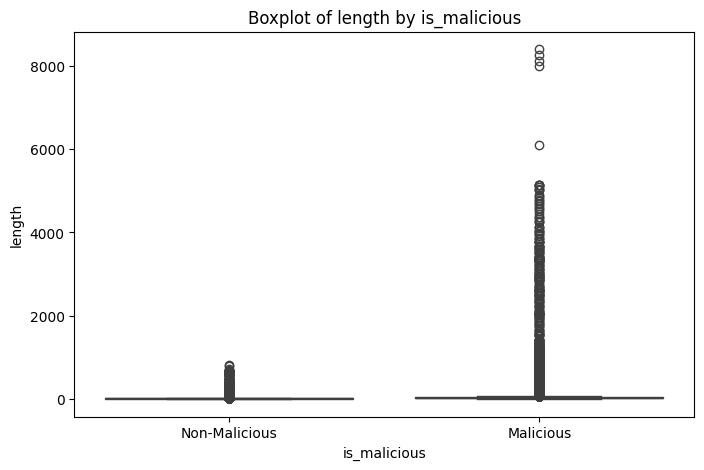

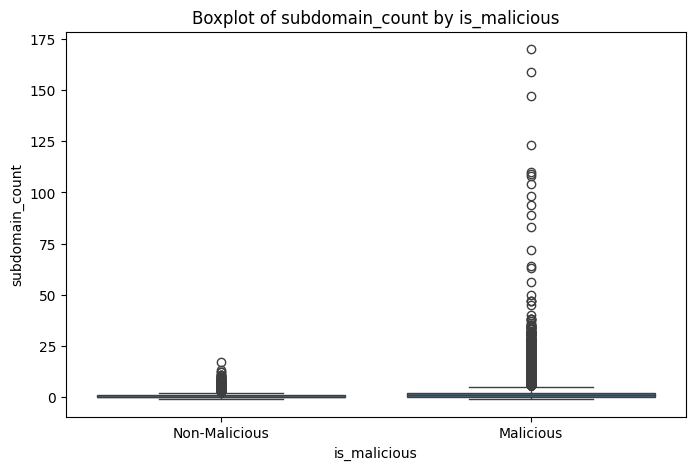

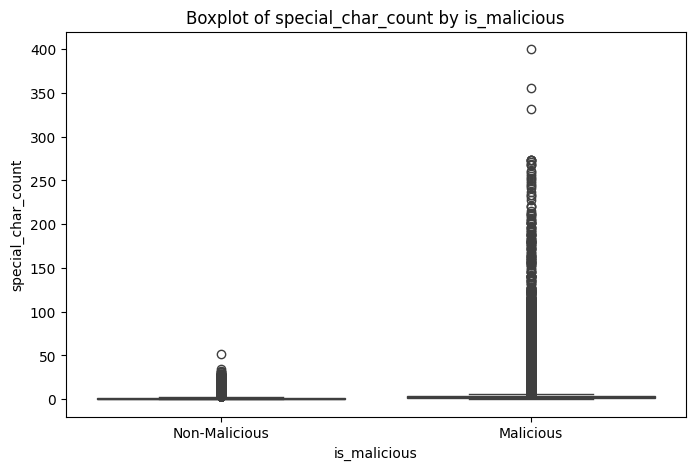

In [7]:
## 악성 여부에 따른 분포 확인
# 변수 목록
variables = ['length', 'subdomain_count', 'special_char_count']

# 박스플롯
for var in variables:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=train_df, x='label', y=var)
    plt.title(f"Boxplot of {var} by is_malicious")
    plt.xlabel("is_malicious")
    plt.ylabel(var)
    plt.xticks([0, 1], ['Non-Malicious', 'Malicious'])
    plt.show()

- 악성 URL은 정상 URL에 비해 평균적으로 더 긴 분포를 띄고 있음.
- 악성 URL은 서브도메인의 길이가 더 길거나 서브도메인 수가 많은 경향이 있음.
- 악성 URL은 정상 URL에 비해 특수문자의 개수가 많음.

### 상관 관계 분석

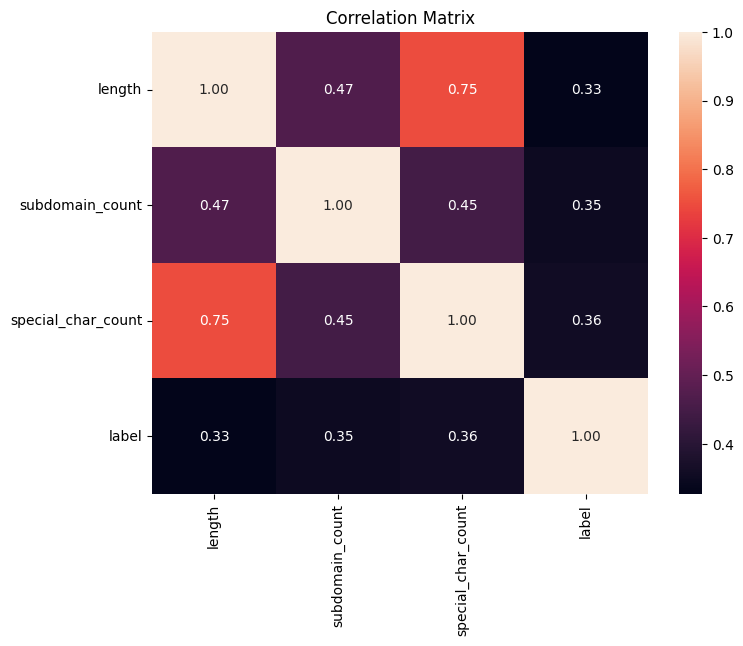

In [8]:
# 상관계수 계산
correlation_matrix = train_df[['length', 'subdomain_count', 'special_char_count', 'label']].corr()

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

- 특수문자 개수와 악성 여부 간의 상관관계는 0.75로, 높은 양의 상관관계를 나타냄.

-  EDA 결과에 따른 가설 설정 

    1. URL의 길이가 길수록 악성 URL일 확률이 높을 것이다. -> 악성 URL은 난독화와 탐지 회피를 위해 길이가 긴 경우가 많다.
    2. 서브도메인이 많을수록 악성 URL일 확률이 높을 것이다. -> 서브도메인은 피싱과 사용자 혼란을 유발하는 데 자주 활용된다.
    3. 특수문자가 많을수록 악성 URL일 확률이 높을 것이다. -> 특수문자는 난독화와 위장 목적으로 사용된다.


## 4. Pre-processing (전처리)

In [9]:
# 학습을 위한 학습 데이터의 피처와 라벨 준비
X = train_df[['length', 'subdomain_count', 'special_char_count']]
y = train_df['label']

# 추론을 위한 평가 데이터의 피처 준비
X_test = test_df[['length', 'subdomain_count', 'special_char_count']]

## 5. K-Fold Model Training (모델 학습)

In [28]:
# XGBoost 학습 및 모델 저장 (K-Fold)
kf = KFold(n_splits=4, shuffle=True, random_state=42)
models = []  # 모델을 저장할 리스트
auc_scores = []

for idx, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    print('-'*40)
    print(f'Fold {idx + 1} 번째 XGBoost 모델을 학습합니다.')
    print('Epoch|         Train AUC             |         Validation AUC')
    
    
    
    # XGBoost 모델 학습
    model = XGBClassifier(
        n_estimators=100, 
        max_depth=6,       
        learning_rate=0.1, 
        random_state=42,
        use_label_encoder=False,  
        callbacks=[EarlyStopping(rounds=5, metric_name='auc')],
        eval_metric="auc",
        tree_method="gpu_hist",   # GPU 사용 설정
        gpu_id=0                  # 사용할 GPU의 ID (기본값: 0)
    )
    
    # 학습 및 Validation 성능 모니터링
    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        verbose=True
    )
    
    models.append(model)  # 모델 저장
    
    # 검증 데이터 예측 및 ROC-AUC 계산
    y_val_pred_prob = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_val_pred_prob)
    print(f"Fold {idx + 1} CV ROC-AUC: {auc:.4f}")
    print('-'*40)
    auc_scores.append(auc)

print(f"K-Fold 평균 ROC-AUC: {np.mean(auc_scores):.4f}")

----------------------------------------
Fold 1 번째 XGBoost 모델을 학습합니다.
Epoch|         Train AUC             |         Validation AUC
[0]	validation_0-auc:0.86098	validation_1-auc:0.86053
[1]	validation_0-auc:0.86337	validation_1-auc:0.86287
[2]	validation_0-auc:0.86432	validation_1-auc:0.86388
[3]	validation_0-auc:0.86457	validation_1-auc:0.86413
[4]	validation_0-auc:0.86456	validation_1-auc:0.86413
[5]	validation_0-auc:0.86460	validation_1-auc:0.86418
[6]	validation_0-auc:0.86465	validation_1-auc:0.86422
[7]	validation_0-auc:0.86461	validation_1-auc:0.86420
[8]	validation_0-auc:0.86477	validation_1-auc:0.86437
[9]	validation_0-auc:0.86501	validation_1-auc:0.86460
[10]	validation_0-auc:0.86512	validation_1-auc:0.86472
[11]	validation_0-auc:0.86524	validation_1-auc:0.86484
[12]	validation_0-auc:0.86525	validation_1-auc:0.86485
[13]	validation_0-auc:0.86534	validation_1-auc:0.86494
[14]	validation_0-auc:0.86536	validation_1-auc:0.86497
[15]	validation_0-auc:0.86538	validation_1-auc:0.8649

## 6. K-Fold Ensemble Inference (K-Fold 앙상블 추론)

In [26]:
# 평가 데이터 추론
# 각 Fold 별 모델의 예측 확률 계산
test_probabilities = np.zeros(len(X_test)) 

for model in models:
    test_probabilities += model.predict_proba(X_test)[:, 1]  # 악성 URL(1)일 확률 합산

# Soft-Voting 앙상블 (Fold 별 모델들의 예측 확률 평균)
test_probabilities /= len(models)
print('Inference Done.')

Inference Done.


## 7. Submission (제출 파일 생성)

In [27]:
# 결과 저장
test_df['probability'] = test_probabilities
test_df[['ID', 'probability']].to_csv('./submission.csv', index=False)
print('Done.')

Done.


In [1]:
from autogluon.common.utils.gpu import get_gpu_count

gpu_count = get_gpu_count()
print(f"Available GPUs: {gpu_count}")

ModuleNotFoundError: No module named 'autogluon.common.utils.gpu'